In [2]:
%matplotlib inline
from datetime import datetime, timedelta
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
import matplotlib.ticker as ticker
import matplotlib.patches as mpatch

import pandas as pd
import numpy as np

from heliopy.data import helios
import astropy.units as u
import astropy.constants as const

# import local_helpers
# from helpers import helioshelp
# from helpers import theory
# import importlib

fitdir = Path('alpha_fits')
# importlib.reload(local_helpers)

Set global figure properties
---

In [4]:
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['figure.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12

figwidth = 6
paperdir = './'
au_to_rs = float(const.R_sun / u.au)

Download and load list of stream dates
---

In [7]:
import urllib
urllib.request.urlretrieve('https://zenodo.org/record/2359201/files/stream_times.csv', 'stream_times.csv')
dates = pd.read_csv('stream_times.csv', parse_dates=[1, 2])

Load in data, and calculate various dervied properties
---

In [4]:
protons, alphas = local_helpers.load_data()
importlib.reload(local_helpers)
protons, alphas = local_helpers.calculate_derived(protons, alphas)

Extract lower/upper quartile and median parameter values
---

In [6]:
ts = []
for _, row in dates.iterrows():
    df = alphas.loc[(alphas.index > row['Start']) &
                    (alphas.index < row['End']) &
                    (alphas['Probe'] == row['Probe'])]
    sr = {}
    for var in ['Ta_perp', 'Ta_par', 'n_a',
                'Ta/Tp_perp', 'Ta/Tp_par', 'Ta/Tp_tot',
                'Tani', 'Beta',
                'Tp_perp', 'Tp_par', 'Tp_ani',
                'eps_p_par', 'eps_a_par',
                'eps_p_perp', 'eps_a_perp']:
        sr[var] = df[var].quantile(0.5)
        sr[var + '_low'] = df[var].quantile(0.25)
        sr[var + '_high'] = df[var].quantile(0.75)
    sr['r_min'] = df['r_sun'].min()
    sr['r_max'] = df['r_sun'].max()
    sr['r_ave'] = (sr['r_min'] + sr['r_max']) / 2
    sr['Time'] = row['Start']
    ts.append(sr)

ts = pd.DataFrame(data=ts)

,Ta_perp_high,Ta_par_low,n_a_low,r_min,r_max,Time
8,3.182669e+06,4.119048e+06,0.856424,0.290327,0.320847,1976-04-14
6,2.264536e+06,1.296313e+06,0.220489,0.634196,0.668551,1976-03-15


In [7]:
def errbar(ax, r_min, r_max, T_median, T_low, T_high, **kwargs):
    yerr = np.atleast_2d([T_median - T_low,
                          T_high - T_median])
    if yerr.shape[0] != 2:
        yerr = yerr.T
    if not 'elinewidth' in kwargs:
        kwargs['elinewidth'] = 1.3
    rave = (r_min + r_max) / 2
    xerr = (r_max - r_min) / 2
    if 'au_to_rs' in kwargs:
        kwargs.pop('au_to_rs')
        rave /= au_to_rs
        xerr /= au_to_rs
    ax.errorbar(rave, T_median,
            xerr=xerr,
            yerr=yerr,
            lw=0, **kwargs)

def var_errbar(ax, var, **kwargs):
    errbar(ax,
           ts['r_min'], ts['r_max'],
           ts[var], ts[var + '_low'], ts[var + '_high'], **kwargs)

In [9]:
def Tp_perp_fit(r):
    return 2.3e5 * (r**-1)
def Tp_par_fit(r):
    return 1.24e5 * (r**-0.5)

In [10]:
def distance_filter(protons, alphas, rmin, rmax):
    keep = (protons['r_sun'] > rmin) & (protons['r_sun'] < rmax)
    return protons.loc[keep], alphas.loc[keep]

In [11]:
class OneAUvalues:
    # Class to store 1 AU temperature values, along with lower/upper quartiles
    def __init__(self, species, lowerq, med, upperq):
        self.lowerq = lowerq
        self.med = med
        self.upperq = upperq
        if species == 'a':
            self.color = 'C2'
        elif species == 'p':
            self.color='C0'
    
    def r(self, use_rs):
        if use_rs:
            return 1 / au_to_rs
        else:
            return 1
            
    def plot_errbar(self, ax, use_rs=False):
        r = self.r(use_rs)
        errbar(ax, r, r, self.lowerq, self.med, self.upperq, color=self.color, elinewidth= 2)
    
    def plot_point(self, ax, use_rs=False, **kwargs):
        r = self.r(use_rs)
        ax.scatter(r, self.med, color=self.color, **kwargs)

Ta_par_1au = OneAUvalues('a', 362213.0, 593682.0, 937360.3125)
Tp_par_1au = OneAUvalues('p', 142383.8125, 199939.921875, 265483.1875)
Ta_perp_1au = OneAUvalues('a', 600620.4375, 759775.9375, 973185.9375)
Tp_perp_1au = OneAUvalues('p', 176186.08984375, 222097.75, 274923.125)

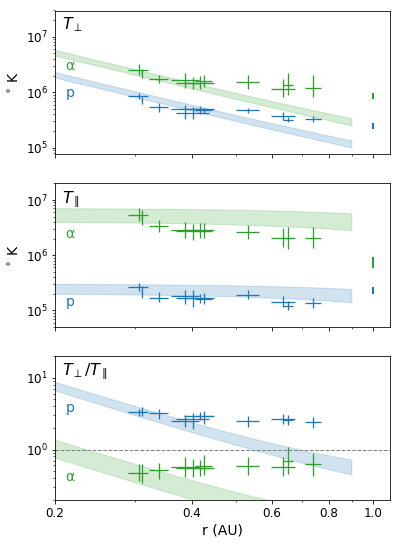

In [12]:
%matplotlib inline
importlib.reload(theory)
# Parameters for CGL prediction
rs = np.linspace(0.1, 0.9, 100) * u.au
r0 = 0.3 * u.au
v1 = 600 * u.km / u.s
v2 = 800 * u.km / u.s

fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(figwidth, figwidth * 3/2))

# Plot temperatures and anisotropies
# axs = axes[:, 0]
linekwargs = {'color': 'C0'}
pkwargs = {'color': 'k', 'linewidth': 1, 'linestyle': '--'}
cglkwargs = {'color': 'k', 'ls': '--', 'lw': 1}
oneAUkwargs = {'elinewidth': 2}
titlesize = 16
titleloc = 0.02, 0.87

# Parallel temperatures
ax = axs[1]
var_errbar(ax, 'Ta_par', color='C2')
var_errbar(ax, 'Tp_par', color='C0')
Ta_par_1au.plot_errbar(ax)
Tp_par_1au.plot_errbar(ax)

ax.fill_between(rs,
                theory.CGL_tpar(4e6, v1, 0, rs, r0),
                theory.CGL_tpar(7e6, v2, 0, rs, r0),
                color='C2', alpha=0.2)
ax.fill_between(rs,
                theory.CGL_tpar(2e5, v1, 0, rs, r0),
                theory.CGL_tpar(3e5, v2, 0, rs, r0),
                color='C0', alpha=0.2)

ax.text(*titleloc, r'$T_{ \parallel}$',
        transform=ax.transAxes, size=titlesize)
ax.set_ylabel('$^{\circ}$ K')
ax.set_ylim(5e4, 2e7)
ax.text(0.03, 0.15, r'$\mathrm{p}$', color='C0',
        fontsize=14, transform=ax.transAxes)
ax.text(0.03, 0.62, r'$\mathrm{\alpha}$', color='C2',
        fontsize=14, transform=ax.transAxes)

# Perpendicular temperatures
ax = axs[0]
var_errbar(ax, 'Ta_perp', color='C2')
var_errbar(ax, 'Tp_perp', color='C0')
Ta_perp_1au.plot_errbar(ax)
Tp_perp_1au.plot_errbar(ax)

ax.fill_between(rs,
                theory.CGL_tperp(2e6, v2, 0, rs, r0),
                theory.CGL_tperp(2.5e6, v1, 0, rs, r0),
                color='C2', alpha=0.2)
ax.fill_between(rs,
                theory.CGL_tperp(8e5, v2, 0, rs, r0),
                theory.CGL_tperp(1e6, v1, 0, rs, r0),
                color='C0', alpha=0.2)

ax.set_ylabel('$^{\circ}$ K')
ax.text(*titleloc, r'$T_{ \perp}$',
        transform=ax.transAxes, size=titlesize)
ax.text(0.03, 0.4, r'$\mathrm{p}$', color='C0',
        fontsize=14, transform=ax.transAxes)
ax.text(0.03, 0.59, r'$\mathrm{\alpha}$', color='C2',
        fontsize=14, transform=ax.transAxes)

# Temperature anisotropies
ax = axs[2]
var_errbar(ax, 'Tani', color='C2')
var_errbar(ax, 'Tp_ani', color='C0')
# errbar(ax, 1, 1, 0.6874308704223853, 0.847580836542309, 1.0349405001272216, color='C0', elinewidth=2)
# errbar(ax, 1, 1, 0.7340419133769771, 0.9382106187103227, 1.3509134807708416, color='C2', elinewidth=2)

# ax.plot([0.1, 1], [2 * 10**0.5, 2], linestyle='--')
ax.fill_between(rs,
                theory.CGL_tperp(2.5e6, v1, 0, rs, r0) / theory.CGL_tpar(4.3e6, v1, 0, rs, r0),
                theory.CGL_tperp(2e6, v2, 0, rs, r0) / theory.CGL_tpar(6e6, v2, 0, rs, r0),
                color='C2', alpha=0.2)
ax.fill_between(rs,
                theory.CGL_tperp(1e6, v1, 0, rs, r0) / theory.CGL_tpar(2.7e5, v1, 0, rs, r0),
                theory.CGL_tperp(8e5, v2, 0, rs, r0) / theory.CGL_tpar(2.8e5, v2, 0, rs, r0),
                color='C0', alpha=0.2)

ax.set_ylim(2e-1, 20)
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
# ax.yaxis.set_major_locator(ticker.FixedLocator([0.2, 0.4, 0.6, 0.8, 1, 5]))
ax.text(*titleloc, r'$T_{ \perp} / T_{\parallel}$',
        transform=ax.transAxes, size=titlesize)
ax.text(0.03, 0.61, r'$\mathrm{p}$', color='C0',
        fontsize=14, transform=ax.transAxes)
ax.text(0.03, 0.13, r'$\mathrm{\alpha}$', color='C2',
        fontsize=14, transform=ax.transAxes)
ax.axhline(1, color='0.5', linewidth=1, linestyle='--')


for ax in axs:
    ax.set_yscale('log')

# x-axis formatting
ax = axs[-1]
ax.set_xlabel('r (AU)')
ax.set_xlim(0.2, 1.09)
ax.set_xscale('log')
ax.xaxis.set_major_locator(ticker.FixedLocator([0.1, 0.2, 0.4, 0.6, 0.8, 1]))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator([0.3, 0.5, 0.7, 0.9]))

# Tempeature ratios
'''axs = axes[:, 1]
ax = axs[0]
var_errbar(ax, 'Ta/Tp_par', color='k')
var_errbar(ax, 'Ta/Tp_perp', color='k', alpha=0.2)

ax.set_yscale('log')
ax.set_ylim(1, 30)

ax = axs[1]
var_errbar(ax, 'Ta/Tp_par', color='k', alpha=0.2)
var_errbar(ax, 'Ta/Tp_perp', color='k')
ax.set_yscale('log')
ax.set_ylim(1, 30)

ax = axs[2]
ax.axis('off')''';
# fig.suptitle('Alpha particle radial trends')
fig.savefig(paperdir + 'alpha_radial_temps.pdf', bbox_inches='tight')

Do a Cranmer-esque plot for different ions
---


Read in other temps

In [14]:
data = []
for angle in [0, 180]:
    df = pd.read_csv('Coronal temps/dolei_pa{}.csv'.format(angle), names=['r', 'Tp_perp'])
    df['Angle'] = angle
    data.append(df)
tperp_corona = pd.concat(data)
tperp_corona.head()

oxygen = pd.read_csv('Coronal temps/cranmer_oxygen.csv', names=['r', 'Tp_perp'])
# close_hydrogen = pd.read_csv('Coronal temps/marsch_hyrdogen.csv', names=['r', 'Tp_perp'])
# close_hydrogen['r'] = ((close_hydrogen['r'].values * u.km) / const.R_sun).astype(float) + 1

tani_corona = pd.read_csv('Coronal temps/dolei_tperp_pa0.csv', names=['r', 'Tp_perp'])
tani_corona['Tp_par'] = pd.read_csv('Coronal temps/dolei_tpar_pa0.csv', names=['r', 'Tp_par']).values[:, 1]
tani_corona['Tani'] = tani_corona['Tp_perp'] / tani_corona['Tp_par']

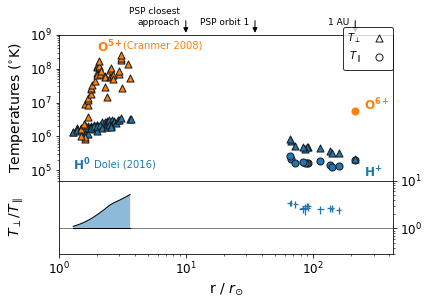

In [15]:
s = 50
one_au_kwargs = dict(marker='o', s=s)
perpkwargs = dict(marker='^', s=s, edgecolors='0.1', linewidths=1)
parkwargs = dict(marker='o', s=s, edgecolors='0.1', linewidths=1)

fig, axs = plt.subplots(nrows=2, sharex=True,
                        figsize=(figwidth, figwidth * 3 / 4),
                        gridspec_kw={'height_ratios': [2, 1]})
fig.subplots_adjust(hspace=0)

ax = axs[0]
# ax.scatter(ts['r_ave'] / au_to_rs, ts['Ta_par'], color='C2', **parkwargs)
ax.scatter(ts['r_ave'] / au_to_rs, ts['Tp_par'], color='C0', **parkwargs)
# Ta_par_1au.plot_point(ax, use_rs=True, **parkwargs)
Tp_par_1au.plot_point(ax, use_rs=True, **parkwargs)

# ax.scatter(ts['r_ave'] / au_to_rs, ts['Ta_perp'], color='C2', **perpkwargs)
ax.scatter(ts['r_ave'] / au_to_rs, ts['Tp_perp'], color='C0', **perpkwargs)
# Ta_perp_1au.plot_point(ax, use_rs=True, **perpkwargs)
Tp_perp_1au.plot_point(ax, use_rs=True, **perpkwargs)


# O6+ temperature from Tracey 2016
ax.scatter(1 / au_to_rs, 222097.75 * 25, color='C1', **one_au_kwargs)

for name, df in tperp_corona.groupby('Angle'):
    ax.scatter(df['r'], df['Tp_perp'], color='C0', **perpkwargs)
    
ax.scatter(oxygen['r'], oxygen['Tp_perp'], color='C1', **perpkwargs)
# ax.scatter(close_hydrogen['r'], close_hydrogen['Tp_perp'], marker='o', color='C0', s=s)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(1, 2 / au_to_rs)
ax.set_ylabel(r'Temperatures ($^{\circ}$K)')
ax.set_ylim(5e4, 1e9)
fig.subplots_adjust(top=0.8)


# Add PSP arrows
ylim = ax.get_ylim()
for r, text in zip((1 / au_to_rs, 35, 10), ('1 AU', 'PSP orbit 1', 'PSP closest\napproach')):
    arrow = mpatch.FancyArrowPatch((r, 3 * ylim[1]), (r, ylim[1]),
                                       arrowstyle='-|>', mutation_scale=10,
                                       facecolor='k', clip_on=False)
    ax.add_patch(arrow)
    ax.text(r * 0.9, ylim[1] * 2, text, horizontalalignment='right', size=9)

# Add fellowship bars
'''bottom = 2e9
for r, color, text in zip((0.092, 0.163, 0.29), ('C0', 'C3', 'k'), ('PSP (end of fellowship)', 'PSP (start of fellowship)', 'Helios')):
    rect = mpatch.Rectangle((r / au_to_rs, bottom),
                            (1 - r) / au_to_rs,
                            bottom * 0.3,
                            clip_on=False, color='k', alpha=0.5)
    ax.add_patch(rect)
    ax.text(1.2 / au_to_rs, bottom, text, size=10)
    bottom = bottom * 2
ax.axvspan(0.092 / au_to_rs, 0.29 / au_to_rs, color='C3', alpha=0.1)
axs[1].axvspan(0.092 / au_to_rs, 0.29 / au_to_rs, color='C3', alpha=0.1)'''
    
ax.text(2, 3e8, r'O$^{\mathbf{5+}}$', size=12, color='C1', weight='bold')
ax.text(3.2, 4e8, r'(Cranmer 2008)', size=10, color='C1')
ax.text(1.3, 1e5, r'H$^{\mathbf{0}}$', size=12, color='C0', weight='bold')
ax.text(1.9, 1.2e5, r'Dolei (2016)', size=10, color='C0')
# ax.text(240, 1e6, r'He$^{\mathbf{2}+}$', size=12, color='C2', weight='bold')
ax.text(250, 6e4, r'H$^{\mathbf{+}}$', size=12, color='C0', weight='bold')
ax.text(250, 6e6, r'O$^{\mathbf{6+}}$', size=12, color='C1', weight='bold')

exp = 1
#ax.plot(np.array([5, 60]), 2.5e6 * 60**exp * np.array([5., 60])**-exp, color='C2')
#ax.plot(np.array([5, 60]), 4e6 * 60**(exp - 1) * np.array([5., 60])**-(exp - 1), color='C2')

exp = 0.5
#ax.plot(np.array([5, 60]), 1e6 * 60**exp * np.array([5., 60])**-exp, color='C0')
#ax.plot(np.array([5, 60]), 0.3e6 * 60**(exp - 0.4) * np.array([5., 60])**-(exp - 0.4), color='C0')

s1 = ax.scatter(1e-10, 1e-10, color='w', label='$T_{\perp}$', **perpkwargs)
s2 = ax.scatter(1e-10, 1e-10, color='w', label='$T_{\parallel}$', **parkwargs)
ax.legend(loc=(0.85, 0.76), handles=[s1, s2], frameon=True, markerfirst=False, edgecolor='k')

# Temperature anisotropies
ax = axs[1]
# var_errbar(ax, 'Tani', color='C2', au_to_rs=True)
var_errbar(ax, 'Tp_ani', color='C0', au_to_rs=True)

ax.fill_between(tani_corona['r'], np.ones(tani_corona.shape[0]), tani_corona['Tani'], alpha=0.5)
ax.plot(tani_corona['r'], np.ones(tani_corona.shape[0]), color='k', lw=1)
ax.plot(tani_corona['r'], tani_corona['Tani'], color='k', lw=1)

ax.set_yscale('log')
ax.set_xlim(1, 2 / au_to_rs)
ax.set_ylim(3e-1, 1e1)
ax.axhline(1, color='k', lw=0.5)
ax.yaxis.tick_right()
ax.set_ylabel(r'$T_{\perp} / T_{\parallel}$')

exp = 1
#ax.plot(np.array([5, 65]), 0.5 * 60**exp * np.array([5., 65])**-exp, color='C2')

exp = 0.4
#ax.plot(np.array([5, 65]), 3 * 60**exp * np.array([5., 65])**-exp, color='C0')

ax.set_xlabel('r / $r_{\odot}$')
fig.align_ylabels()

# fig.savefig(paperdir + 'alpha_summary.pdf', bbox_inches='tight')
fig.savefig('heavy_ion_summary.pdf')

In [16]:
def threshold(a, b, beta_0):
    def t(beta):
        return 1 + a / (beta - beta_0)**b
    return t

0.30000192 0.39999771
0.71132725 0.76901567


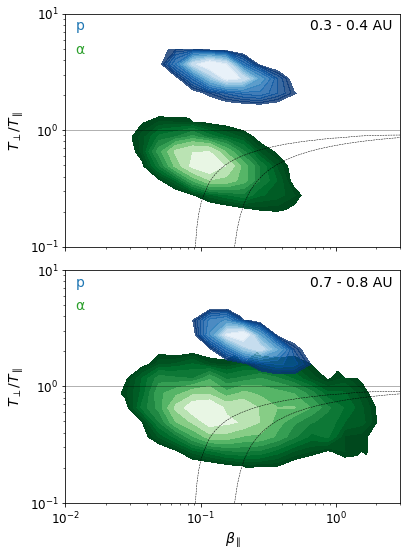

In [24]:
rs = [0.3, 0.7]
fig, axs = plt.subplots(nrows=len(rs), sharex=True, sharey=True, figsize=(figwidth, figwidth * 1.5))
for r, ax in zip(rs, axs):
    rprotons, ralphas = distance_filter(protons, alphas, r, r + 0.1)
    print(rprotons['r_sun'].min(), rprotons['r_sun'].max())
    bins = (np.logspace(-2, 1, 25), np.logspace(-2, 1, 25))
    h, xedges, yedges = np.histogram2d(ralphas['Beta'].dropna(),
                                       ralphas['Tani'].dropna(),
                                       bins=bins)
    cmin = 10
    h[h < cmin] = np.nan
    h /= np.nanmax(h)
    xcentres = (xedges[1:] + xedges[:-1]) / 2
    ycentres = (yedges[1:] + yedges[:-1]) / 2
    levels = np.logspace(-1, 0, 12)
    # print(levels)
    ax.contourf(xcentres, ycentres, h.T, levels=levels, cmap='Greens_r')
    
    h, xedges, yedges = np.histogram2d(rprotons['Beta'].dropna(),
                                       rprotons['Tani'].dropna(),
                                       bins=bins)
    h[h < cmin] = np.nan
    h /= np.nanmax(h)
    ax.contourf(xcentres, ycentres, h.T, levels=levels, cmap='Blues_r', alpha=0.8)
    # ax.contour(xcentres, ycentres, h.T, levels=levels, colors='k', linewidths=0.1)
    '''
    ax.hist2d(rprotons['Beta'].dropna(),
              rprotons['Tani'].dropna(),
              bins=(np.logspace(-2, 0, 80), np.logspace(0, 1, 40)),
              cmap='Blues', cmin=10, norm=mcolor.LogNorm())
    ax.hist2d(ralphas['Beta'].dropna(),
              ralphas['Tani'].dropna(),
              bins=(np.logspace(-2, 1, 25), np.logspace(-1, 1, 25)),
              cmap='Greens', cmin=10, norm=mcolor.LogNorm())  
    '''

    # betas = np.logspace(-2, 1, 100)
    # x.plot(betas, threshold(1, 0.6, 0)(betas), color='k', lw=1, linestyle='--')
    # ax.plot(betas, threshold(-0.534, 0.693, -0.1)(betas), color='k', lw=1)
    # ax.plot(betas, threshold(-0.789, 0.985, -0.31)(betas), color='k', lw=1)
    
    for name in (['1e-3', '1e-2']):
        inst_data = np.loadtxt('alpha_instability_curve_{}.csv'.format(name))
        ax.plot(inst_data[:, 0], inst_data[:, 1], lw=0.5, color='k', linestyle='--')
    #inst_data = np.loadtxt('proton_instability_curve.csv'.format(0.3))
    #ax.scatter(inst_data[:, 0], inst_data[:, 1],color='k')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-2, 3e0)
    ax.set_ylim(1e-1, 1e1)
    ax.set_ylabel(r'$T_{\perp} / T_{\parallel}$')
    ax.axhline(1, linestyle='-', linewidth=1, color='k', alpha=0.3)
    
    ax.text(0.73, 0.93, '{} - {} AU'.format(r, int(10 * r + 1) / 10),
            fontsize=14, transform=ax.transAxes)
    ax.text(0.03, 0.93, r'$\mathrm{p}$', color='C0',
            fontsize=14, transform=ax.transAxes)
    ax.text(0.03, 0.83, r'$\mathrm{\alpha}$', color='C2',
            fontsize=14, transform=ax.transAxes)

ax.set_xlabel(r'$\beta_{\parallel}$')
fig.subplots_adjust(hspace=0.1)
fig.savefig(paperdir + 'alpha_ani_beta.pdf', bbox_inches='tight')